In [1]:
%matplotlib inline

In [2]:
import pandas
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import timeit
from functools import partial
import tabulate
import os.path
matplotlib.style.use('ggplot')

DATA_FILE = 'cs111_svm_dataset.csv'

In [3]:
data = pandas.read_csv(DATA_FILE)
BIAS_COLUMN = 'bias'
LABEL_COLUMN = 'Classification'

data[BIAS_COLUMN] = 1
data[LABEL_COLUMN].replace(0, -1, inplace=True)


\begin{figure}[ht]
	\label{fig:data}
	\includegraphics[width=0.95\textwidth]{data_only_plot.png}
	\caption{Plot of the raw data}
\end{figure}



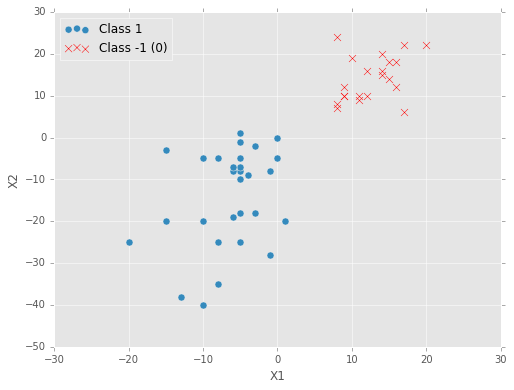

In [4]:
OUTPUT_DIR = r'/Users/guydavidson/Documents/CS111/svm_gradient_descent'
LATEX_FIGURE_FORMAT = """
\\begin{{figure}}[ht]
\t\\label{{fig:{label}}}
\t\\includegraphics[width=0.95\\textwidth]{{{name}}}
\t\\caption{{{caption}}}
\\end{{figure}}
"""

X_MIN = -30
X_MAX = 30
Y_MIN = -50
Y_MAX = 30

def save_and_print_latex(figure_name, caption, label):
    plt.savefig(os.path.join(OUTPUT_DIR, figure_name))
    print LATEX_FIGURE_FORMAT.format(name=figure_name, label=label, caption=caption)

    
def line_from_theta(theta, x_range):
    b0, b1, b2 = theta
    return -1.0 * (b0 + b1 * x_range) / b2


def plot_data(data, theta=None, figure_name=None, label='', caption=''):
    ax = data[data[LABEL_COLUMN] == 1].plot(kind='scatter', x='X1', 
                                            y='X2', marker='o', s=50,
                                            label='Class 1', figsize=(8, 6))
    data[data[LABEL_COLUMN] == -1].plot(kind='scatter', x='X1', y='X2', 
                                        marker='x', s=50, 
                                        c='red', label='Class -1 (0)', ax=ax)
    ax.set_xlabel('X1')
    ax.set_xlim(X_MIN, X_MAX)
    ax.set_ylim(Y_MIN, Y_MAX)
    
    if theta is not None:
        x_min = data.min()['X1']
        x_max = data.max()['X1']
        x_range = np.linspace(X_MIN, X_MAX)

        ax.plot(x_range, line_from_theta(theta, x_range), color='black', ls='--')
        
    ax.legend(loc=2)
    
    if figure_name is not None:
        save_and_print_latex(figure_name, caption, label)
    
    plt.show()
    
plot_data(data, figure_name='data_only_plot.png', 
          label='data', caption='Plot of the raw data')

In [6]:
DATA_COLUMN_PREFIX = 'X'

def generate_relevant_columns(data, include_bias=True, prefix=DATA_COLUMN_PREFIX):
    columns = data.filter(like=prefix).columns
    if include_bias:
        columns = columns.insert(0, BIAS_COLUMN)
        
    return columns

def loss_function(data, theta, label_column=LABEL_COLUMN, 
                  data_cols_generator=generate_relevant_columns):
    return np.log(1.0 + np.exp(-1.0 * data[label_column] * 
                             data.filter(items=data_cols_generator(data))
                               .values.dot(theta)))


def error_function(data, theta, label_column=LABEL_COLUMN, 
                   data_cols_generator=generate_relevant_columns):
    return np.mean(loss_function(data, theta, label_column, data_cols_generator))
    

def generate_partial_derivatives(label_column=LABEL_COLUMN, 
                                 data_cols_generator=generate_relevant_columns):
    return pandas.concat([-1 * data[label_column] * data[col] 
                          for col in data_cols_generator(data)], axis=1)


def gradient(data, theta, partial_derivatives, 
             label_column=LABEL_COLUMN, 
             data_cols_generator=generate_relevant_columns):
    return partial_derivatives.multiply(1.0 / (
            1.0 + np.exp(data[label_column] * data.filter(
                    items=data_cols_generator(data)).values.dot(theta))), 
                                        axis=0).sum()


GRADIENT_CHECK_STEP = 0.001


def gradient_check(data, theta, step=GRADIENT_CHECK_STEP,
                   label_column=LABEL_COLUMN, 
                   data_cols_generator=generate_relevant_columns):
    """
    Implement gradient checking using the centered formula for the derivative:
    f'(x) = (f(x + h) - f(x - h)) / 2h
    """
    step_configurations = ([step, 0, 0], [0, step, 0], [0, 0, step])
    
    gradients = [(loss_function(data, theta + step_config) - \
                  loss_function(data, theta - step_config)) /  \
                (2 * step) for step_config in step_configurations]
    
    return [grad.sum() for grad in gradients]


def compare_gradients(step=GRADIENT_CHECK_STEP, label_column=LABEL_COLUMN, 
                      data_cols_generator=generate_relevant_columns):
    test_theta = np.random.random(3)
    partial_derivatives = generate_partial_derivatives(label_column, 
                                                       data_cols_generator)
    
    return gradient_check(data, test_theta, step, 
                          label_column, data_cols_generator) - \
            gradient(data, test_theta, partial_derivatives, 
                     label_column, data_cols_generator)


LEARNING_RATE = 1.0
DEFAULT_EPOCHS = 1000
DEFAULT_GRAPH_INTERVAL = 10
MIN_DELTA_ERROR = 10 ** -7


def split_data_into_batches(data, batch_size=None):
    if batch_size is None:
        return [data]
    
    if 1 == batch_size:
        return data.sample(frac=1)
    
    shuffled_rows = range(len(data))
    np.random.shuffle(shuffled_rows)
    
    return [data.iloc[shuffled_rows[i * batch_size:(i + 1) * batch_size]] 
            for i in range(len(data) / batch_size)]


def train_model(data, theta=None, batch_size=None, num_epochs=DEFAULT_EPOCHS, 
                learning_rate=LEARNING_RATE, min_delta_error=MIN_DELTA_ERROR, 
                should_print=True, should_graph=False, 
                graph_interval=DEFAULT_GRAPH_INTERVAL,
                label_column=LABEL_COLUMN, 
                data_cols_generator=generate_relevant_columns):
    if batch_size > len(data):
        raise ValueError('Batch size cannot be larger than the entire data. Aborting...')
    
    if theta is None:
        theta = np.random.rand(3) * 10
        
    learning_rate = float(learning_rate)
        
    last_error = float('inf')

    partial_derivatives = generate_partial_derivatives(label_column, data_cols_generator)
    
    for i in xrange(num_epochs):
        for batch in split_data_into_batches(data, batch_size):        
            error = error_function(data, theta, label_column, data_cols_generator)
            if should_print:
                print 'In epoch {i} the error is {error}'.format(i=i, error=error)

            if last_error - error < min_delta_error:
                if should_print:
                    print 'Reached a change in error below the minimum, terminating'
                
                return theta

            last_error = error

            if should_graph and 0 == i % graph_interval:
                plot_data(data, 
                          theta,
                          figure_name='learning_plot_epoch_{i}.png'.format(i=i), 
                          label='epoch_{i}'.format(i=i), 
                          caption='Epoch {i} with a learning rate $\\eta={lr}$, $err={err:.4e}$'
                              .format(i=i, err=error, lr=learning_rate))

            theta_grad = gradient(data, theta, partial_derivatives, 
                                  label_column, data_cols_generator)
            theta -= learning_rate * theta_grad
        
    return theta


DEFAULT_LEARNING_RATES = [10.0, 5.0, 2.0, 1.0, 0.5]
DEFAULT_BATCH_SIZES = [1, 10, 25, None]

def evaluate_convergence_rate(data, learning_rates=DEFAULT_LEARNING_RATES, 
                              batch_sizes=DEFAULT_BATCH_SIZES):
    
    results = [['Learning Rate'] + batch_sizes] + \
            [[rate] + 
                   [timeit.timeit(partial(train_model, data, should_print=False, 
                                          learning_rate=rate, batch_size=batch), number=10)
                    for batch in batch_sizes]
                 for rate in learning_rates]
    
    print tabulate.tabulate(results, tablefmt="latex")
    

In epoch 0 the error is 93.7821719494

\begin{figure}[ht]
	\label{fig:epoch_0}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_0.png}
	\caption{Epoch 0 with a learning rate $\eta=0.1$, $err=9.3782e+01$}
\end{figure}



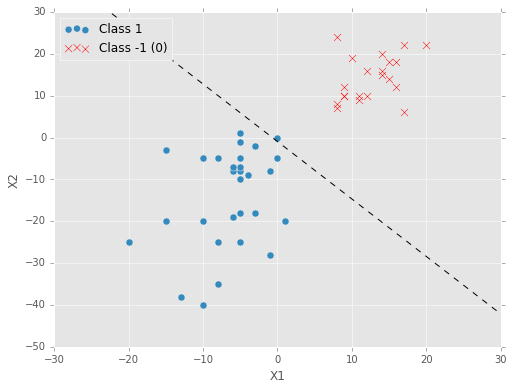

In epoch 1 the error is 0.00035749370933
In epoch 2 the error is 0.000356866550315
In epoch 3 the error is 0.00035624156938
In epoch 4 the error is 0.000355618755262
In epoch 5 the error is 0.000354998096776
In epoch 6 the error is 0.000354379582814
In epoch 7 the error is 0.000353763202341
In epoch 8 the error is 0.000353148944402
In epoch 9 the error is 0.000352536798112
In epoch 10 the error is 0.000351926752663

\begin{figure}[ht]
	\label{fig:epoch_10}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_10.png}
	\caption{Epoch 10 with a learning rate $\eta=0.1$, $err=3.5193e-04$}
\end{figure}



/Users/guydavidson/Virtualenvs/dev/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: overflow encountered in exp


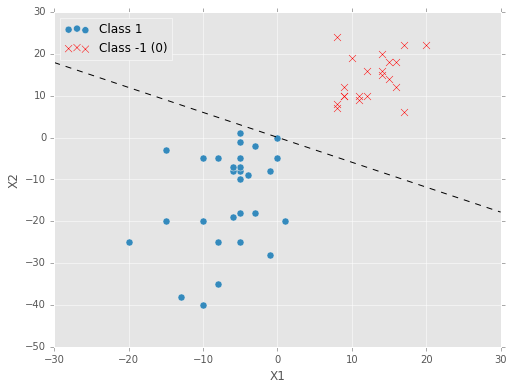

In epoch 11 the error is 0.000351318797318
In epoch 12 the error is 0.000350712921416
In epoch 13 the error is 0.000350109114364
In epoch 14 the error is 0.000349507365644
In epoch 15 the error is 0.000348907664807
In epoch 16 the error is 0.000348310001474
In epoch 17 the error is 0.000347714365338
In epoch 18 the error is 0.000347120746158
In epoch 19 the error is 0.000346529133765
In epoch 20 the error is 0.000345939518054

\begin{figure}[ht]
	\label{fig:epoch_20}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_20.png}
	\caption{Epoch 20 with a learning rate $\eta=0.1$, $err=3.4594e-04$}
\end{figure}



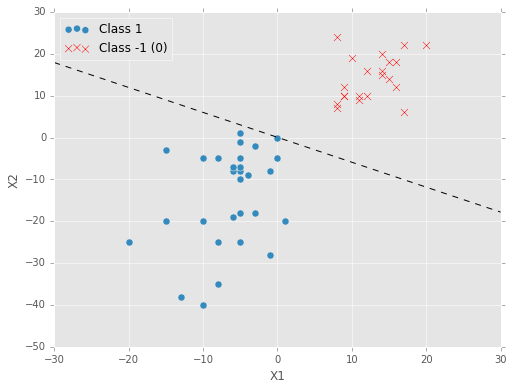

In epoch 21 the error is 0.000345351888991
In epoch 22 the error is 0.000344766236607
In epoch 23 the error is 0.000344182551
In epoch 24 the error is 0.000343600822333
In epoch 25 the error is 0.000343021040834
In epoch 26 the error is 0.000342443196798
In epoch 27 the error is 0.000341867280582
In epoch 28 the error is 0.000341293282607
In epoch 29 the error is 0.000340721193357
In epoch 30 the error is 0.000340151003378

\begin{figure}[ht]
	\label{fig:epoch_30}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_30.png}
	\caption{Epoch 30 with a learning rate $\eta=0.1$, $err=3.4015e-04$}
\end{figure}



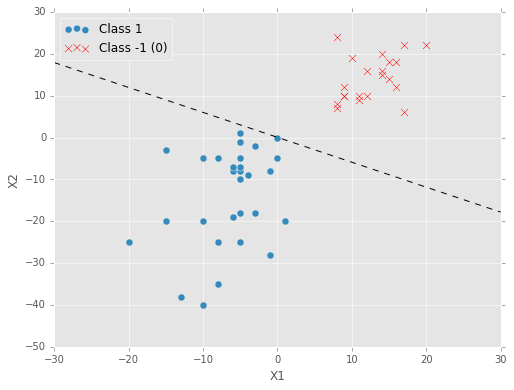

In epoch 31 the error is 0.000339582703281
In epoch 32 the error is 0.000339016283734
In epoch 33 the error is 0.00033845173547
In epoch 34 the error is 0.000337889049281
In epoch 35 the error is 0.000337328216018
In epoch 36 the error is 0.000336769226594
In epoch 37 the error is 0.000336212071978
In epoch 38 the error is 0.000335656743202
In epoch 39 the error is 0.000335103231351
In epoch 40 the error is 0.000334551527572

\begin{figure}[ht]
	\label{fig:epoch_40}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_40.png}
	\caption{Epoch 40 with a learning rate $\eta=0.1$, $err=3.3455e-04$}
\end{figure}



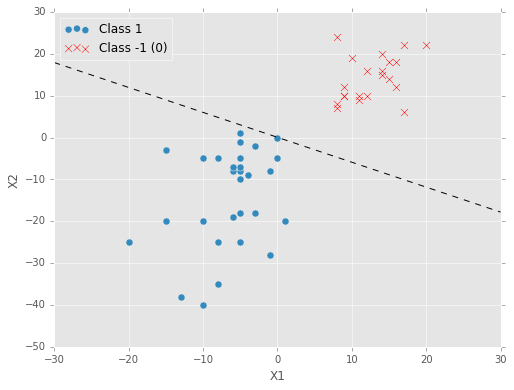

In epoch 41 the error is 0.000334001623066
In epoch 42 the error is 0.000333453509093
In epoch 43 the error is 0.000332907176969
In epoch 44 the error is 0.000332362618064
In epoch 45 the error is 0.000331819823806
In epoch 46 the error is 0.000331278785675
In epoch 47 the error is 0.000330739495209
In epoch 48 the error is 0.000330201943997
In epoch 49 the error is 0.000329666123684
In epoch 50 the error is 0.000329132025966

\begin{figure}[ht]
	\label{fig:epoch_50}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_50.png}
	\caption{Epoch 50 with a learning rate $\eta=0.1$, $err=3.2913e-04$}
\end{figure}



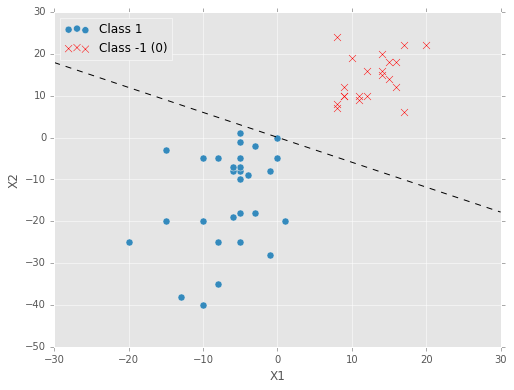

In epoch 51 the error is 0.000328599642593
In epoch 52 the error is 0.000328068965369
In epoch 53 the error is 0.000327539986147
In epoch 54 the error is 0.000327012696833
In epoch 55 the error is 0.000326487089384
In epoch 56 the error is 0.000325963155808
In epoch 57 the error is 0.000325440888163
In epoch 58 the error is 0.000324920278558
In epoch 59 the error is 0.000324401319149
In epoch 60 the error is 0.000323884002145

\begin{figure}[ht]
	\label{fig:epoch_60}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_60.png}
	\caption{Epoch 60 with a learning rate $\eta=0.1$, $err=3.2388e-04$}
\end{figure}



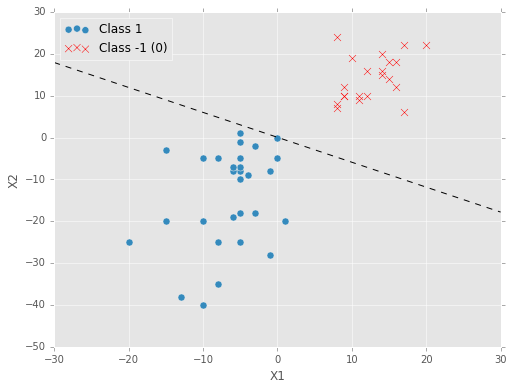

In epoch 61 the error is 0.0003233683198
In epoch 62 the error is 0.000322854264418
In epoch 63 the error is 0.000322341828353
In epoch 64 the error is 0.000321831004003
In epoch 65 the error is 0.000321321783816
In epoch 66 the error is 0.000320814160286
In epoch 67 the error is 0.000320308125954
In epoch 68 the error is 0.000319803673406
In epoch 69 the error is 0.000319300795275
In epoch 70 the error is 0.000318799484239

\begin{figure}[ht]
	\label{fig:epoch_70}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_70.png}
	\caption{Epoch 70 with a learning rate $\eta=0.1$, $err=3.1880e-04$}
\end{figure}



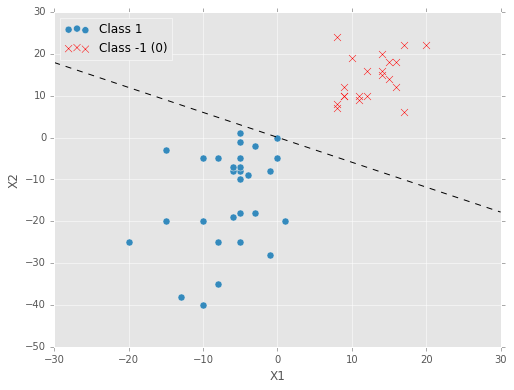

In epoch 71 the error is 0.000318299733022
In epoch 72 the error is 0.000317801534392
In epoch 73 the error is 0.000317304881161
In epoch 74 the error is 0.000316809766187
In epoch 75 the error is 0.000316316182369
In epoch 76 the error is 0.000315824122652
In epoch 77 the error is 0.000315333580024
In epoch 78 the error is 0.000314844547513
In epoch 79 the error is 0.000314357018193
In epoch 80 the error is 0.000313870985177

\begin{figure}[ht]
	\label{fig:epoch_80}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_80.png}
	\caption{Epoch 80 with a learning rate $\eta=0.1$, $err=3.1387e-04$}
\end{figure}



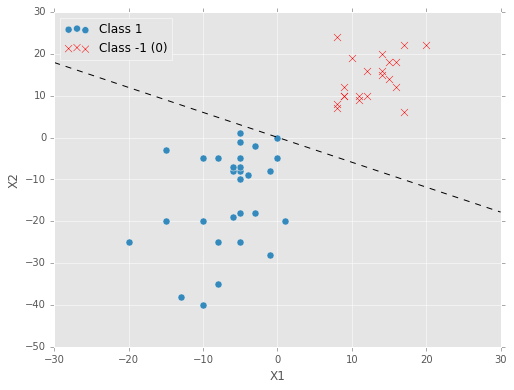

In epoch 81 the error is 0.000313386441623
In epoch 82 the error is 0.000312903380727
In epoch 83 the error is 0.00031242179573
In epoch 84 the error is 0.000311941679911
In epoch 85 the error is 0.000311463026591
In epoch 86 the error is 0.00031098582913
In epoch 87 the error is 0.00031051008093
In epoch 88 the error is 0.000310035775431
In epoch 89 the error is 0.000309562906112
In epoch 90 the error is 0.000309091466493

\begin{figure}[ht]
	\label{fig:epoch_90}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_90.png}
	\caption{Epoch 90 with a learning rate $\eta=0.1$, $err=3.0909e-04$}
\end{figure}



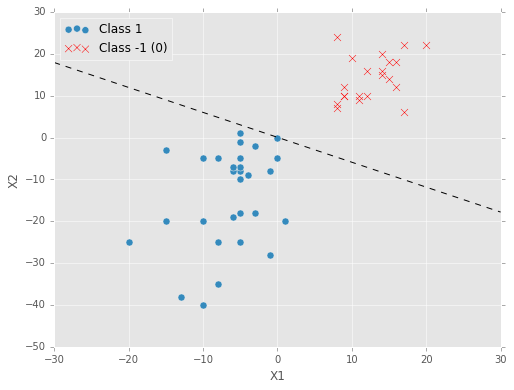

In epoch 91 the error is 0.000308621450131
In epoch 92 the error is 0.000308152850623
In epoch 93 the error is 0.000307685661603
In epoch 94 the error is 0.000307219876744
In epoch 95 the error is 0.000306755489754
In epoch 96 the error is 0.000306292494383
In epoch 97 the error is 0.000305830884414
In epoch 98 the error is 0.000305370653669
In epoch 99 the error is 0.000304911796006
In epoch 100 the error is 0.000304454305318

\begin{figure}[ht]
	\label{fig:epoch_100}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_100.png}
	\caption{Epoch 100 with a learning rate $\eta=0.1$, $err=3.0445e-04$}
\end{figure}



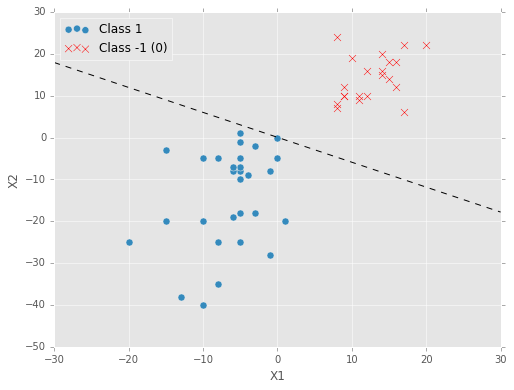

In epoch 101 the error is 0.000303998175536
In epoch 102 the error is 0.000303543400627
In epoch 103 the error is 0.00030308997459
In epoch 104 the error is 0.000302637891463
In epoch 105 the error is 0.000302187145318
In epoch 106 the error is 0.000301737730261
In epoch 107 the error is 0.000301289640433
In epoch 108 the error is 0.000300842870008
In epoch 109 the error is 0.000300397413196
In epoch 110 the error is 0.000299953264239

\begin{figure}[ht]
	\label{fig:epoch_110}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_110.png}
	\caption{Epoch 110 with a learning rate $\eta=0.1$, $err=2.9995e-04$}
\end{figure}



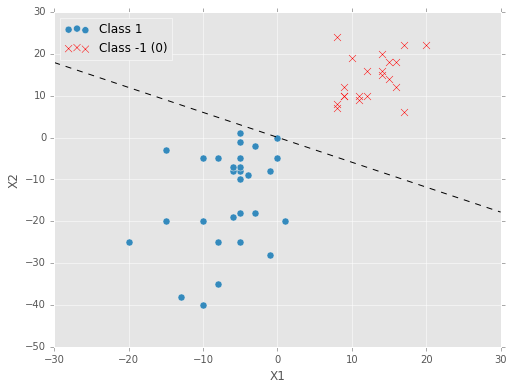

In epoch 111 the error is 0.000299510417414
In epoch 112 the error is 0.00029906886703
In epoch 113 the error is 0.000298628607429
In epoch 114 the error is 0.000298189632986
In epoch 115 the error is 0.00029775193811
In epoch 116 the error is 0.000297315517239
In epoch 117 the error is 0.000296880364847
In epoch 118 the error is 0.000296446475437
In epoch 119 the error is 0.000296013843544
In epoch 120 the error is 0.000295582463735

\begin{figure}[ht]
	\label{fig:epoch_120}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_120.png}
	\caption{Epoch 120 with a learning rate $\eta=0.1$, $err=2.9558e-04$}
\end{figure}



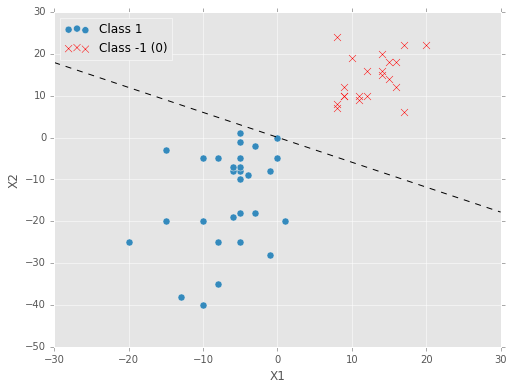

In epoch 121 the error is 0.000295152330607
In epoch 122 the error is 0.000294723438791
In epoch 123 the error is 0.000294295782945
In epoch 124 the error is 0.00029386935776
In epoch 125 the error is 0.000293444157955
In epoch 126 the error is 0.000293020178281
In epoch 127 the error is 0.000292597413518
In epoch 128 the error is 0.000292175858476
In epoch 129 the error is 0.000291755507994
In epoch 130 the error is 0.000291336356941

\begin{figure}[ht]
	\label{fig:epoch_130}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_130.png}
	\caption{Epoch 130 with a learning rate $\eta=0.1$, $err=2.9134e-04$}
\end{figure}



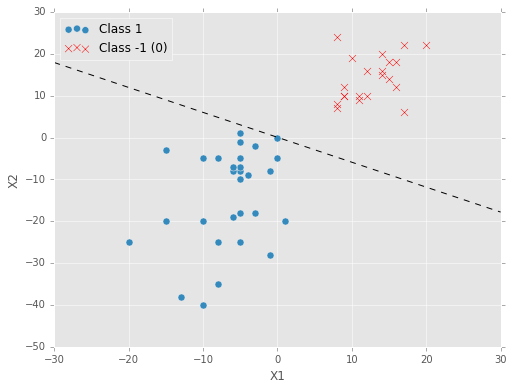

In epoch 131 the error is 0.000290918400214
In epoch 132 the error is 0.000290501632739
In epoch 133 the error is 0.000290086049471
In epoch 134 the error is 0.000289671645394
In epoch 135 the error is 0.000289258415518
In epoch 136 the error is 0.000288846354884
In epoch 137 the error is 0.000288435458558
In epoch 138 the error is 0.000288025721635
In epoch 139 the error is 0.000287617139238
In epoch 140 the error is 0.000287209706516

\begin{figure}[ht]
	\label{fig:epoch_140}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_140.png}
	\caption{Epoch 140 with a learning rate $\eta=0.1$, $err=2.8721e-04$}
\end{figure}



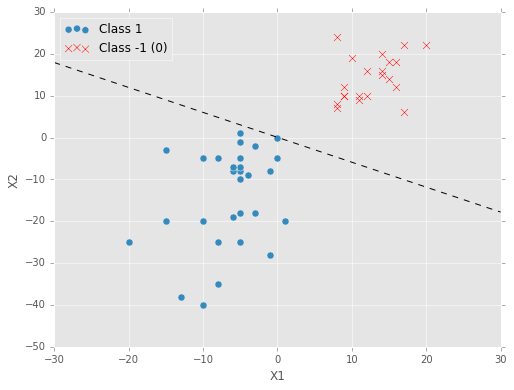

In epoch 141 the error is 0.000286803418645
In epoch 142 the error is 0.000286398270829
In epoch 143 the error is 0.000285994258299
In epoch 144 the error is 0.00028559137631
In epoch 145 the error is 0.000285189620145
In epoch 146 the error is 0.000284788985113
In epoch 147 the error is 0.00028438946655
In epoch 148 the error is 0.000283991059815
In epoch 149 the error is 0.000283593760296
In epoch 150 the error is 0.000283197563403

\begin{figure}[ht]
	\label{fig:epoch_150}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_150.png}
	\caption{Epoch 150 with a learning rate $\eta=0.1$, $err=2.8320e-04$}
\end{figure}



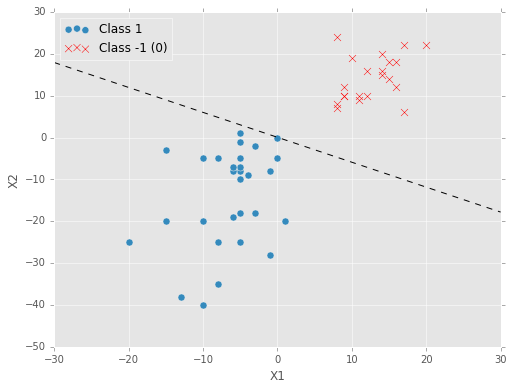

In epoch 151 the error is 0.000282802464573
In epoch 152 the error is 0.000282408459269
In epoch 153 the error is 0.000282015542978
In epoch 154 the error is 0.00028162371121
In epoch 155 the error is 0.000281232959501
In epoch 156 the error is 0.000280843283413
In epoch 157 the error is 0.00028045467853
In epoch 158 the error is 0.000280067140461
In epoch 159 the error is 0.000279680664838
In epoch 160 the error is 0.000279295247317

\begin{figure}[ht]
	\label{fig:epoch_160}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_160.png}
	\caption{Epoch 160 with a learning rate $\eta=0.1$, $err=2.7930e-04$}
\end{figure}



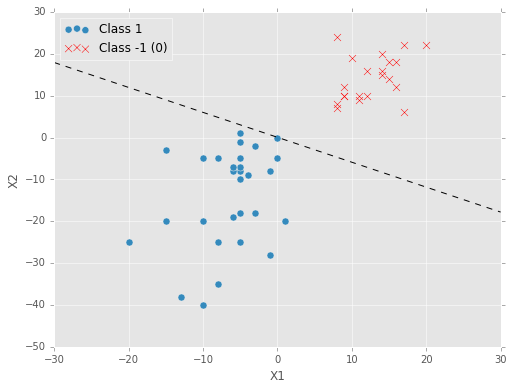

In epoch 161 the error is 0.000278910883579
In epoch 162 the error is 0.000278527569327
In epoch 163 the error is 0.000278145300287
In epoch 164 the error is 0.000277764072209
In epoch 165 the error is 0.000277383880865
In epoch 166 the error is 0.000277004722052
In epoch 167 the error is 0.000276626591586
In epoch 168 the error is 0.000276249485309
In epoch 169 the error is 0.000275873399083
In epoch 170 the error is 0.000275498328793

\begin{figure}[ht]
	\label{fig:epoch_170}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_170.png}
	\caption{Epoch 170 with a learning rate $\eta=0.1$, $err=2.7550e-04$}
\end{figure}



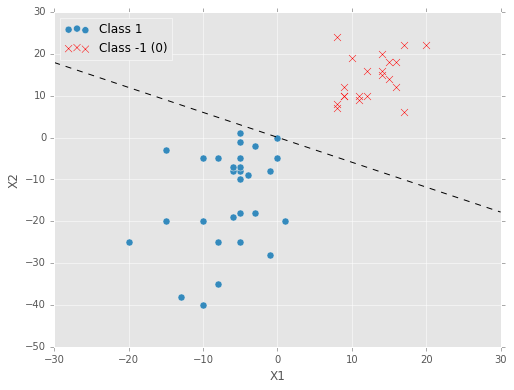

In epoch 171 the error is 0.000275124270346
In epoch 172 the error is 0.000274751219671
In epoch 173 the error is 0.000274379172719
In epoch 174 the error is 0.000274008125462
In epoch 175 the error is 0.000273638073894
In epoch 176 the error is 0.000273269014029
In epoch 177 the error is 0.000272900941904
In epoch 178 the error is 0.000272533853576
In epoch 179 the error is 0.000272167745123
In epoch 180 the error is 0.000271802612643

\begin{figure}[ht]
	\label{fig:epoch_180}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_180.png}
	\caption{Epoch 180 with a learning rate $\eta=0.1$, $err=2.7180e-04$}
\end{figure}



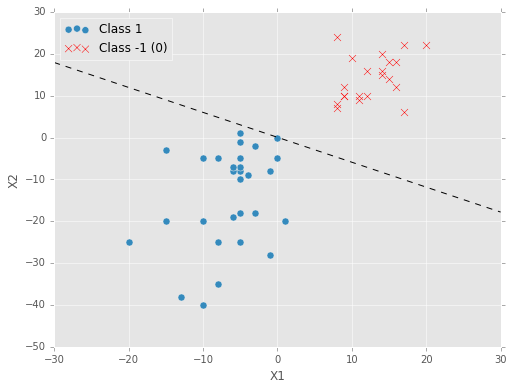

In epoch 181 the error is 0.000271438452257
In epoch 182 the error is 0.000271075260104
In epoch 183 the error is 0.000270713032345
In epoch 184 the error is 0.000270351765159
In epoch 185 the error is 0.000269991454748
In epoch 186 the error is 0.000269632097332
In epoch 187 the error is 0.000269273689151
In epoch 188 the error is 0.000268916226465
In epoch 189 the error is 0.000268559705554
In epoch 190 the error is 0.000268204122716

\begin{figure}[ht]
	\label{fig:epoch_190}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_190.png}
	\caption{Epoch 190 with a learning rate $\eta=0.1$, $err=2.6820e-04$}
\end{figure}



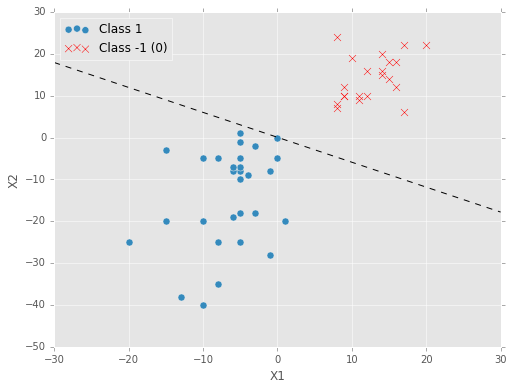

In epoch 191 the error is 0.000267849474271
In epoch 192 the error is 0.000267495756555
In epoch 193 the error is 0.000267142965925
In epoch 194 the error is 0.000266791098757
In epoch 195 the error is 0.000266440151444
In epoch 196 the error is 0.0002660901204
In epoch 197 the error is 0.000265741002056
In epoch 198 the error is 0.000265392792862
In epoch 199 the error is 0.000265045489286
In epoch 200 the error is 0.000264699087816

\begin{figure}[ht]
	\label{fig:epoch_200}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_200.png}
	\caption{Epoch 200 with a learning rate $\eta=0.1$, $err=2.6470e-04$}
\end{figure}



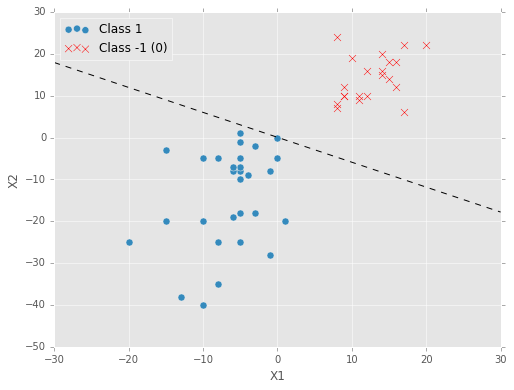

In epoch 201 the error is 0.000264353584955
In epoch 202 the error is 0.000264008977226
In epoch 203 the error is 0.000263665261169
In epoch 204 the error is 0.000263322433344
In epoch 205 the error is 0.000262980490324
In epoch 206 the error is 0.000262639428705
In epoch 207 the error is 0.000262299245096
In epoch 208 the error is 0.000261959936126
In epoch 209 the error is 0.000261621498439
In epoch 210 the error is 0.000261283928699

\begin{figure}[ht]
	\label{fig:epoch_210}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_210.png}
	\caption{Epoch 210 with a learning rate $\eta=0.1$, $err=2.6128e-04$}
\end{figure}



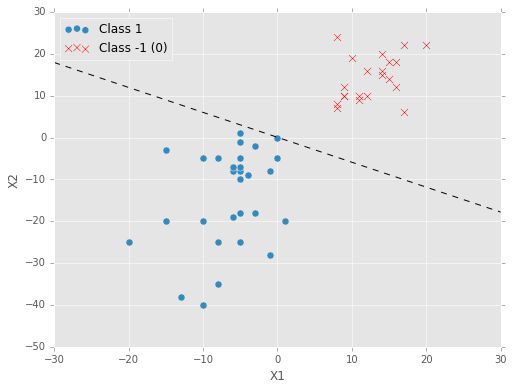

In epoch 211 the error is 0.000260947223584
In epoch 212 the error is 0.000260611379791
In epoch 213 the error is 0.000260276394032
In epoch 214 the error is 0.000259942263038
In epoch 215 the error is 0.000259608983554
In epoch 216 the error is 0.000259276552342
In epoch 217 the error is 0.000258944966182
In epoch 218 the error is 0.000258614221869
In epoch 219 the error is 0.000258284316214
In epoch 220 the error is 0.000257955246044

\begin{figure}[ht]
	\label{fig:epoch_220}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_220.png}
	\caption{Epoch 220 with a learning rate $\eta=0.1$, $err=2.5796e-04$}
\end{figure}



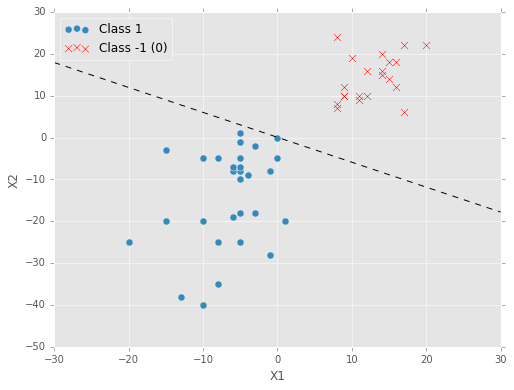

In epoch 221 the error is 0.000257627008203
In epoch 222 the error is 0.00025729959955
In epoch 223 the error is 0.000256973016959
In epoch 224 the error is 0.000256647257321
In epoch 225 the error is 0.000256322317541
In epoch 226 the error is 0.000255998194543
In epoch 227 the error is 0.000255674885261
In epoch 228 the error is 0.000255352386648
In epoch 229 the error is 0.000255030695672
In epoch 230 the error is 0.000254709809314

\begin{figure}[ht]
	\label{fig:epoch_230}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_230.png}
	\caption{Epoch 230 with a learning rate $\eta=0.1$, $err=2.5471e-04$}
\end{figure}



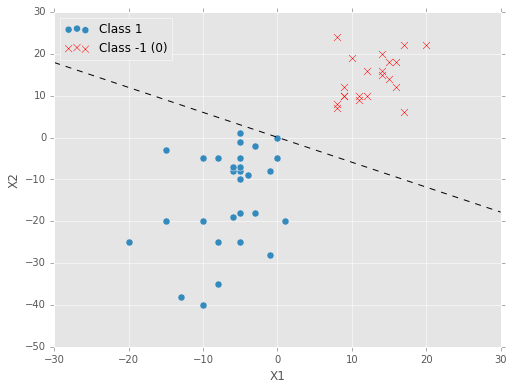

In epoch 231 the error is 0.000254389724572
In epoch 232 the error is 0.000254070438458
In epoch 233 the error is 0.000253751947998
In epoch 234 the error is 0.000253434250235
In epoch 235 the error is 0.000253117342224
In epoch 236 the error is 0.000252801221036
In epoch 237 the error is 0.000252485883756
In epoch 238 the error is 0.000252171327484
In epoch 239 the error is 0.000251857549334
In epoch 240 the error is 0.000251544546432

\begin{figure}[ht]
	\label{fig:epoch_240}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_240.png}
	\caption{Epoch 240 with a learning rate $\eta=0.1$, $err=2.5154e-04$}
\end{figure}



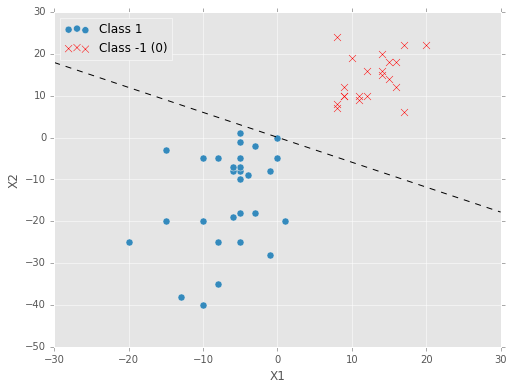

In epoch 241 the error is 0.000251232315922
In epoch 242 the error is 0.000250920854959
In epoch 243 the error is 0.000250610160713
In epoch 244 the error is 0.000250300230367
In epoch 245 the error is 0.00024999106112
In epoch 246 the error is 0.000249682650181
In epoch 247 the error is 0.000249374994776
In epoch 248 the error is 0.000249068092142
In epoch 249 the error is 0.000248761939532
In epoch 250 the error is 0.00024845653421

\begin{figure}[ht]
	\label{fig:epoch_250}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_250.png}
	\caption{Epoch 250 with a learning rate $\eta=0.1$, $err=2.4846e-04$}
\end{figure}



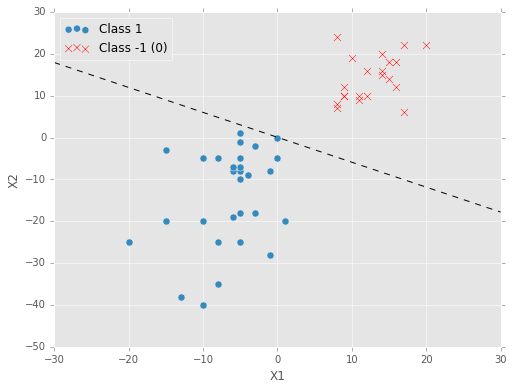

In epoch 251 the error is 0.000248151873453
In epoch 252 the error is 0.000247847954554
In epoch 253 the error is 0.000247544774816
In epoch 254 the error is 0.000247242331558
In epoch 255 the error is 0.000246940622108
In epoch 256 the error is 0.000246639643811
In epoch 257 the error is 0.000246339394021
In epoch 258 the error is 0.000246039870109
In epoch 259 the error is 0.000245741069454
In epoch 260 the error is 0.00024544298945

\begin{figure}[ht]
	\label{fig:epoch_260}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_260.png}
	\caption{Epoch 260 with a learning rate $\eta=0.1$, $err=2.4544e-04$}
\end{figure}



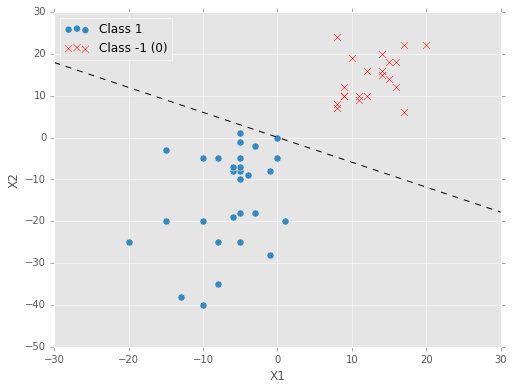

In epoch 261 the error is 0.000245145627505
In epoch 262 the error is 0.000244848981036
In epoch 263 the error is 0.000244553047474
In epoch 264 the error is 0.000244257824262
In epoch 265 the error is 0.000243963308856
In epoch 266 the error is 0.000243669498723
In epoch 267 the error is 0.000243376391343
In epoch 268 the error is 0.000243083984207
In epoch 269 the error is 0.000242792274819
In epoch 270 the error is 0.000242501260693

\begin{figure}[ht]
	\label{fig:epoch_270}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_270.png}
	\caption{Epoch 270 with a learning rate $\eta=0.1$, $err=2.4250e-04$}
\end{figure}



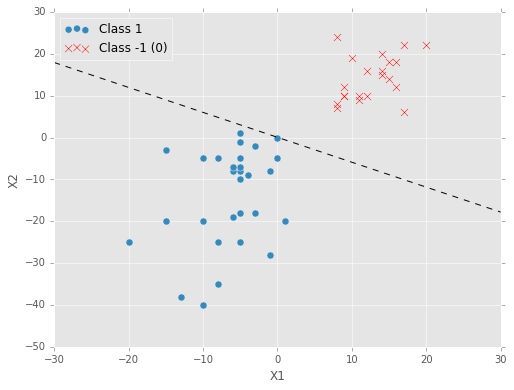

In epoch 271 the error is 0.000242210939357
In epoch 272 the error is 0.000241921308348
In epoch 273 the error is 0.000241632365218
In epoch 274 the error is 0.000241344107528
In epoch 275 the error is 0.000241056532851
In epoch 276 the error is 0.000240769638772
In epoch 277 the error is 0.000240483422887
In epoch 278 the error is 0.000240197882803
In epoch 279 the error is 0.000239913016138
In epoch 280 the error is 0.000239628820523

\begin{figure}[ht]
	\label{fig:epoch_280}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_280.png}
	\caption{Epoch 280 with a learning rate $\eta=0.1$, $err=2.3963e-04$}
\end{figure}



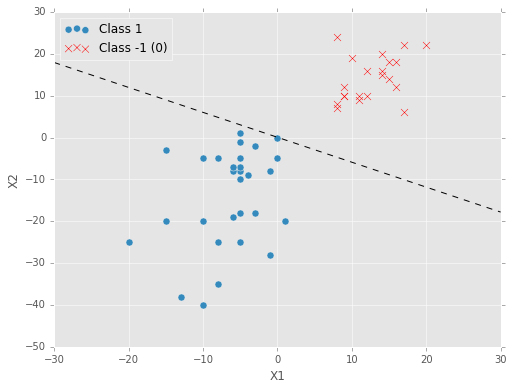

In epoch 281 the error is 0.000239345293597
In epoch 282 the error is 0.000239062433013
In epoch 283 the error is 0.000238780236432
In epoch 284 the error is 0.00023849870153
In epoch 285 the error is 0.000238217825989
In epoch 286 the error is 0.000237937607506
In epoch 287 the error is 0.000237658043785
In epoch 288 the error is 0.000237379132544
In epoch 289 the error is 0.000237100871509
In epoch 290 the error is 0.000236823258418

\begin{figure}[ht]
	\label{fig:epoch_290}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_290.png}
	\caption{Epoch 290 with a learning rate $\eta=0.1$, $err=2.3682e-04$}
\end{figure}



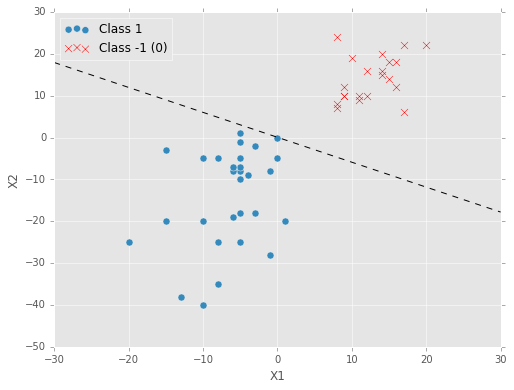

In epoch 291 the error is 0.000236546291019
In epoch 292 the error is 0.00023626996707
In epoch 293 the error is 0.000235994284341
In epoch 294 the error is 0.000235719240609
In epoch 295 the error is 0.000235444833665
In epoch 296 the error is 0.000235171061308
In epoch 297 the error is 0.000234897921346
In epoch 298 the error is 0.000234625411601
In epoch 299 the error is 0.0002343535299
In epoch 300 the error is 0.000234082274084

\begin{figure}[ht]
	\label{fig:epoch_300}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_300.png}
	\caption{Epoch 300 with a learning rate $\eta=0.1$, $err=2.3408e-04$}
\end{figure}



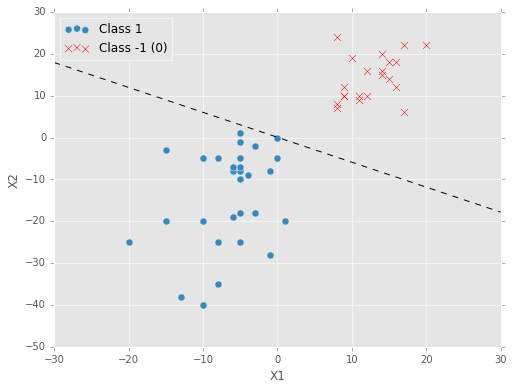

In epoch 301 the error is 0.000233811642002
In epoch 302 the error is 0.000233541631513
In epoch 303 the error is 0.000233272240486
In epoch 304 the error is 0.000233003466799
In epoch 305 the error is 0.000232735308341
In epoch 306 the error is 0.00023246776301
In epoch 307 the error is 0.000232200828713
In epoch 308 the error is 0.000231934503366
In epoch 309 the error is 0.000231668784896
In epoch 310 the error is 0.000231403671239

\begin{figure}[ht]
	\label{fig:epoch_310}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_310.png}
	\caption{Epoch 310 with a learning rate $\eta=0.1$, $err=2.3140e-04$}
\end{figure}



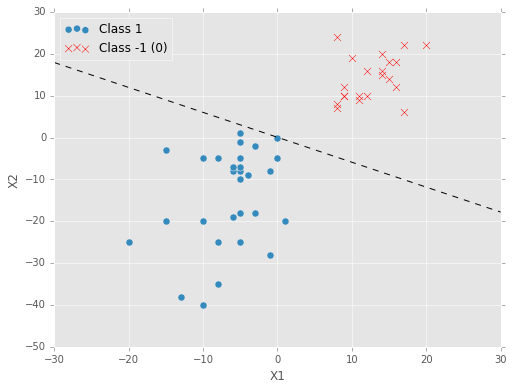

In epoch 311 the error is 0.000231139160339
In epoch 312 the error is 0.000230875250152
In epoch 313 the error is 0.00023061193864
In epoch 314 the error is 0.000230349223776
In epoch 315 the error is 0.000230087103541
In epoch 316 the error is 0.000229825575928
In epoch 317 the error is 0.000229564638935
In epoch 318 the error is 0.000229304290571
In epoch 319 the error is 0.000229044528854
In epoch 320 the error is 0.000228785351811

\begin{figure}[ht]
	\label{fig:epoch_320}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_320.png}
	\caption{Epoch 320 with a learning rate $\eta=0.1$, $err=2.2879e-04$}
\end{figure}



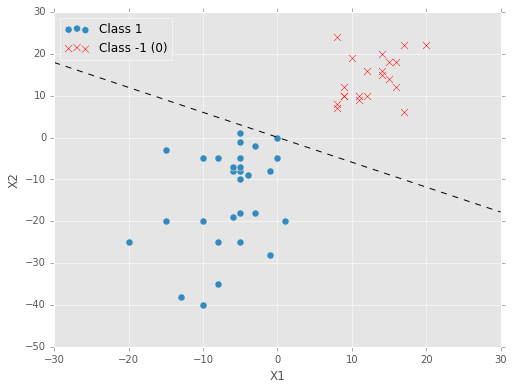

In epoch 321 the error is 0.000228526757477
In epoch 322 the error is 0.000228268743896
In epoch 323 the error is 0.000228011309121
In epoch 324 the error is 0.000227754451214
In epoch 325 the error is 0.000227498168245
In epoch 326 the error is 0.000227242458292
In epoch 327 the error is 0.000226987319444
In epoch 328 the error is 0.000226732749795
In epoch 329 the error is 0.00022647874745
In epoch 330 the error is 0.000226225310522

\begin{figure}[ht]
	\label{fig:epoch_330}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_330.png}
	\caption{Epoch 330 with a learning rate $\eta=0.1$, $err=2.2623e-04$}
\end{figure}



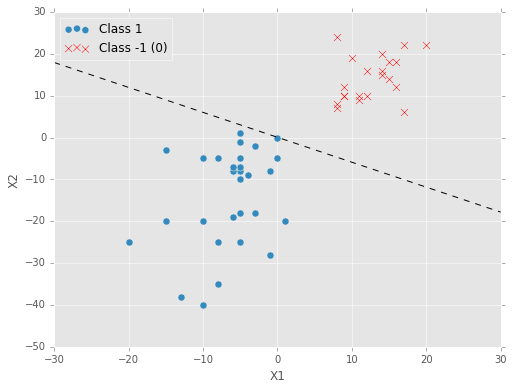

In epoch 331 the error is 0.000225972437132
In epoch 332 the error is 0.000225720125408
In epoch 333 the error is 0.000225468373488
In epoch 334 the error is 0.000225217179518
In epoch 335 the error is 0.000224966541652
In epoch 336 the error is 0.000224716458051
In epoch 337 the error is 0.000224466926886
In epoch 338 the error is 0.000224217946335
In epoch 339 the error is 0.000223969514584
In epoch 340 the error is 0.000223721629827

\begin{figure}[ht]
	\label{fig:epoch_340}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_340.png}
	\caption{Epoch 340 with a learning rate $\eta=0.1$, $err=2.2372e-04$}
\end{figure}



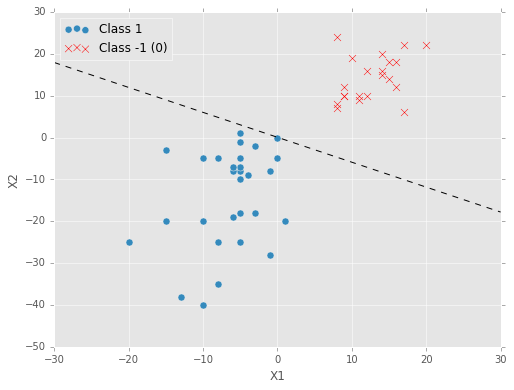

In epoch 341 the error is 0.000223474290265
In epoch 342 the error is 0.000223227494108
In epoch 343 the error is 0.000222981239574
In epoch 344 the error is 0.000222735524889
In epoch 345 the error is 0.000222490348285
In epoch 346 the error is 0.000222245708002
In epoch 347 the error is 0.00022200160229
In epoch 348 the error is 0.000221758029404
In epoch 349 the error is 0.000221514987607
In epoch 350 the error is 0.000221272475171

\begin{figure}[ht]
	\label{fig:epoch_350}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_350.png}
	\caption{Epoch 350 with a learning rate $\eta=0.1$, $err=2.2127e-04$}
\end{figure}



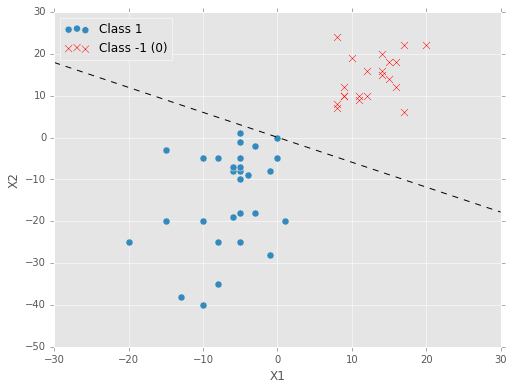

In epoch 351 the error is 0.000221030490375
In epoch 352 the error is 0.000220789031503
In epoch 353 the error is 0.00022054809685
In epoch 354 the error is 0.000220307684716
In epoch 355 the error is 0.000220067793409
In epoch 356 the error is 0.000219828421244
In epoch 357 the error is 0.000219589566544
In epoch 358 the error is 0.000219351227639
In epoch 359 the error is 0.000219113402865
In epoch 360 the error is 0.000218876090567

\begin{figure}[ht]
	\label{fig:epoch_360}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_360.png}
	\caption{Epoch 360 with a learning rate $\eta=0.1$, $err=2.1888e-04$}
\end{figure}



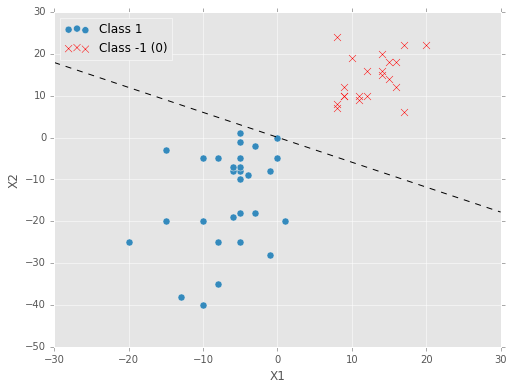

In epoch 361 the error is 0.000218639289095
In epoch 362 the error is 0.000218402996808
In epoch 363 the error is 0.000218167212071
In epoch 364 the error is 0.000217931933255
In epoch 365 the error is 0.000217697158741
In epoch 366 the error is 0.000217462886914
In epoch 367 the error is 0.000217229116166
In epoch 368 the error is 0.000216995844898
In epoch 369 the error is 0.000216763071515
In epoch 370 the error is 0.000216530794432

\begin{figure}[ht]
	\label{fig:epoch_370}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_370.png}
	\caption{Epoch 370 with a learning rate $\eta=0.1$, $err=2.1653e-04$}
\end{figure}



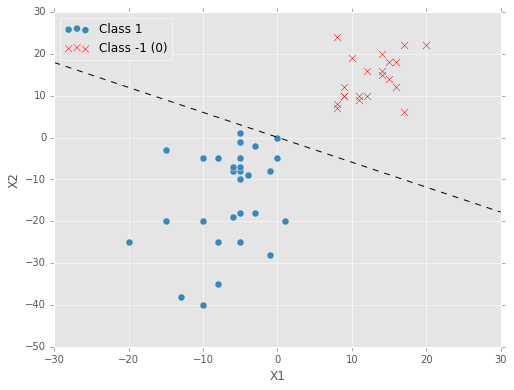

In epoch 371 the error is 0.000216299012068
In epoch 372 the error is 0.000216067722849
In epoch 373 the error is 0.000215836925208
In epoch 374 the error is 0.000215606617587
In epoch 375 the error is 0.00021537679843
In epoch 376 the error is 0.000215147466192
In epoch 377 the error is 0.000214918619331
In epoch 378 the error is 0.000214690256313
In epoch 379 the error is 0.000214462375611
In epoch 380 the error is 0.000214234975704

\begin{figure}[ht]
	\label{fig:epoch_380}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_380.png}
	\caption{Epoch 380 with a learning rate $\eta=0.1$, $err=2.1423e-04$}
\end{figure}



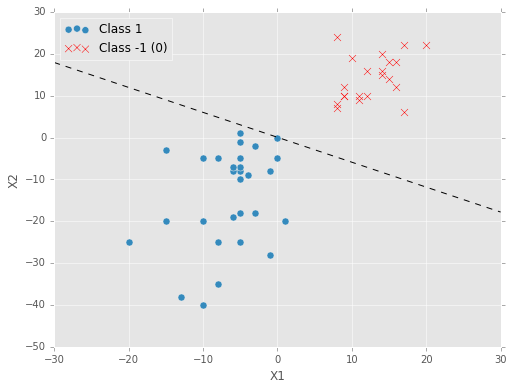

In epoch 381 the error is 0.000214008055076
In epoch 382 the error is 0.00021378161222
In epoch 383 the error is 0.000213555645633
In epoch 384 the error is 0.00021333015382
In epoch 385 the error is 0.000213105135289
In epoch 386 the error is 0.000212880588559
In epoch 387 the error is 0.000212656512152
In epoch 388 the error is 0.000212432904596
In epoch 389 the error is 0.000212209764427
In epoch 390 the error is 0.000211987090186

\begin{figure}[ht]
	\label{fig:epoch_390}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_390.png}
	\caption{Epoch 390 with a learning rate $\eta=0.1$, $err=2.1199e-04$}
\end{figure}



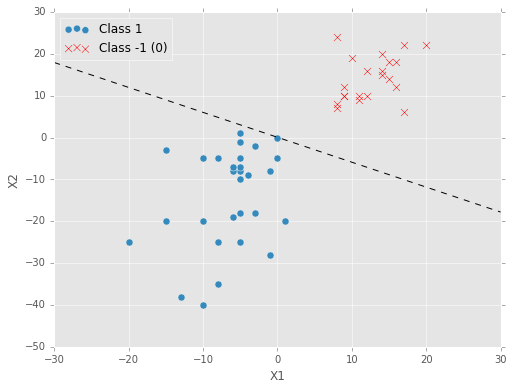

In epoch 391 the error is 0.00021176488042
In epoch 392 the error is 0.000211543133682
In epoch 393 the error is 0.000211321848531
In epoch 394 the error is 0.000211101023532
In epoch 395 the error is 0.000210880657256
In epoch 396 the error is 0.000210660748281
In epoch 397 the error is 0.000210441295188
In epoch 398 the error is 0.000210222296567
In epoch 399 the error is 0.000210003751012
In epoch 400 the error is 0.000209785657123

\begin{figure}[ht]
	\label{fig:epoch_400}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_400.png}
	\caption{Epoch 400 with a learning rate $\eta=0.1$, $err=2.0979e-04$}
\end{figure}



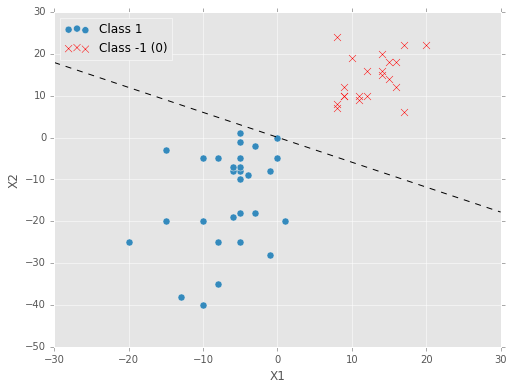

In epoch 401 the error is 0.000209568013506
In epoch 402 the error is 0.000209350818773
In epoch 403 the error is 0.00020913407154
In epoch 404 the error is 0.000208917770432
In epoch 405 the error is 0.000208701914076
In epoch 406 the error is 0.000208486501107
In epoch 407 the error is 0.000208271530165
In epoch 408 the error is 0.000208056999895
In epoch 409 the error is 0.000207842908947
In epoch 410 the error is 0.000207629255979

\begin{figure}[ht]
	\label{fig:epoch_410}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_410.png}
	\caption{Epoch 410 with a learning rate $\eta=0.1$, $err=2.0763e-04$}
\end{figure}



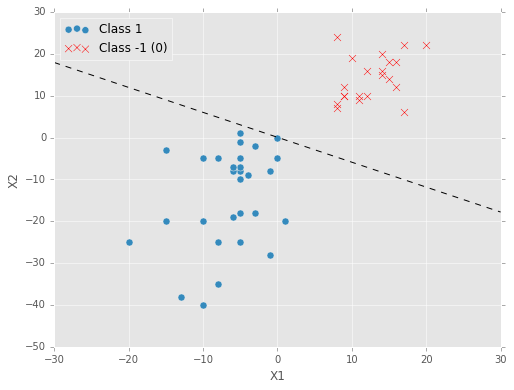

In epoch 411 the error is 0.000207416039652
In epoch 412 the error is 0.000207203258633
In epoch 413 the error is 0.000206990911595
In epoch 414 the error is 0.000206778997216
In epoch 415 the error is 0.000206567514179
In epoch 416 the error is 0.000206356461173
In epoch 417 the error is 0.000206145836892
In epoch 418 the error is 0.000205935640035
In epoch 419 the error is 0.000205725869307
In epoch 420 the error is 0.000205516523418

\begin{figure}[ht]
	\label{fig:epoch_420}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_420.png}
	\caption{Epoch 420 with a learning rate $\eta=0.1$, $err=2.0552e-04$}
\end{figure}



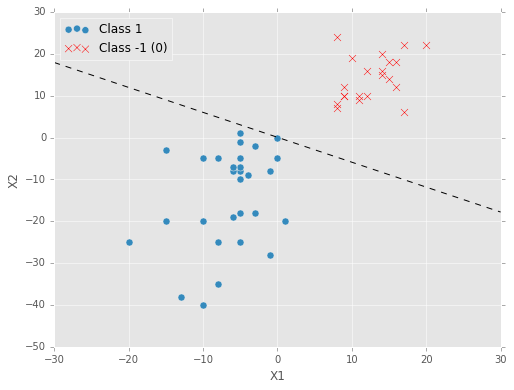

In epoch 421 the error is 0.000205307601081
In epoch 422 the error is 0.000205099101019
In epoch 423 the error is 0.000204891021954
In epoch 424 the error is 0.000204683362619
In epoch 425 the error is 0.000204476121748
In epoch 426 the error is 0.000204269298083
In epoch 427 the error is 0.000204062890367
In epoch 428 the error is 0.000203856897352
In epoch 429 the error is 0.000203651317794
In epoch 430 the error is 0.000203446150453

\begin{figure}[ht]
	\label{fig:epoch_430}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_430.png}
	\caption{Epoch 430 with a learning rate $\eta=0.1$, $err=2.0345e-04$}
\end{figure}



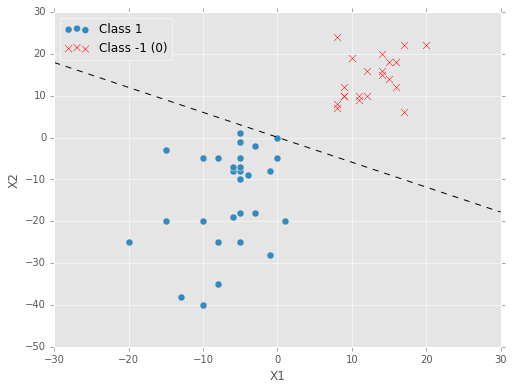

In epoch 431 the error is 0.000203241394094
In epoch 432 the error is 0.000203037047488
In epoch 433 the error is 0.00020283310941
In epoch 434 the error is 0.000202629578639
In epoch 435 the error is 0.000202426453962
In epoch 436 the error is 0.000202223734167
In epoch 437 the error is 0.000202021418049
In epoch 438 the error is 0.000201819504408
In epoch 439 the error is 0.000201617992047
In epoch 440 the error is 0.000201416879776

\begin{figure}[ht]
	\label{fig:epoch_440}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_440.png}
	\caption{Epoch 440 with a learning rate $\eta=0.1$, $err=2.0142e-04$}
\end{figure}



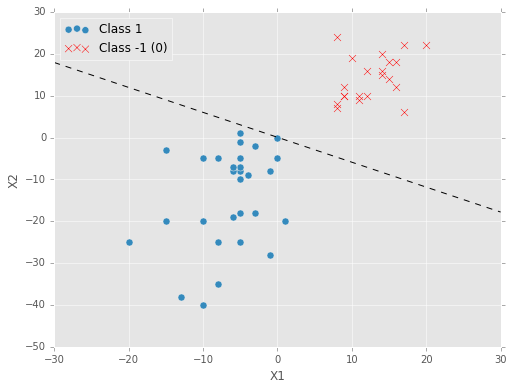

In epoch 441 the error is 0.000201216166407
In epoch 442 the error is 0.000201015850759
In epoch 443 the error is 0.000200815931655
In epoch 444 the error is 0.000200616407922
In epoch 445 the error is 0.000200417278393
In epoch 446 the error is 0.000200218541903
In epoch 447 the error is 0.000200020197294
In epoch 448 the error is 0.000199822243411
In epoch 449 the error is 0.000199624679106
In epoch 450 the error is 0.000199427503232

\begin{figure}[ht]
	\label{fig:epoch_450}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_450.png}
	\caption{Epoch 450 with a learning rate $\eta=0.1$, $err=1.9943e-04$}
\end{figure}



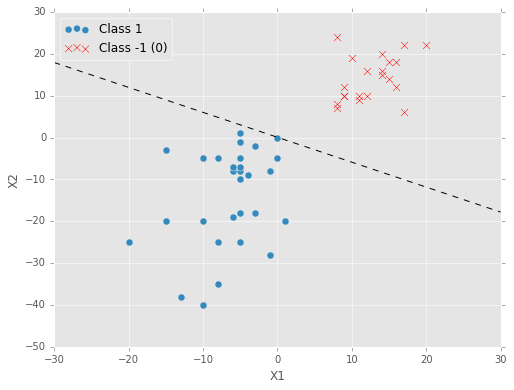

In epoch 451 the error is 0.000199230714649
In epoch 452 the error is 0.000199034312221
In epoch 453 the error is 0.000198838294815
In epoch 454 the error is 0.000198642661304
In epoch 455 the error is 0.000198447410566
In epoch 456 the error is 0.00019825254148
In epoch 457 the error is 0.000198058052934
In epoch 458 the error is 0.000197863943816
In epoch 459 the error is 0.000197670213021
In epoch 460 the error is 0.000197476859448

\begin{figure}[ht]
	\label{fig:epoch_460}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_460.png}
	\caption{Epoch 460 with a learning rate $\eta=0.1$, $err=1.9748e-04$}
\end{figure}



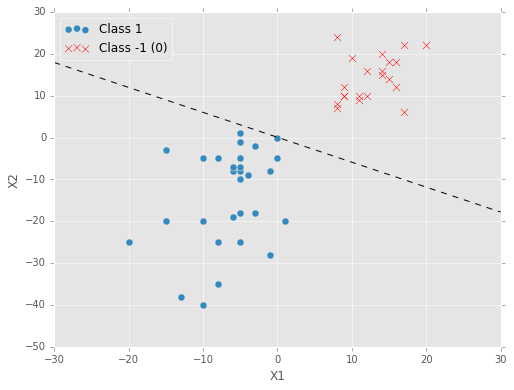

In epoch 461 the error is 0.000197283881999
In epoch 462 the error is 0.000197091279582
In epoch 463 the error is 0.000196899051107
In epoch 464 the error is 0.000196707195489
In epoch 465 the error is 0.00019651571165
In epoch 466 the error is 0.000196324598512
In epoch 467 the error is 0.000196133855003
In epoch 468 the error is 0.000195943480056
In epoch 469 the error is 0.000195753472606
In epoch 470 the error is 0.000195563831593

\begin{figure}[ht]
	\label{fig:epoch_470}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_470.png}
	\caption{Epoch 470 with a learning rate $\eta=0.1$, $err=1.9556e-04$}
\end{figure}



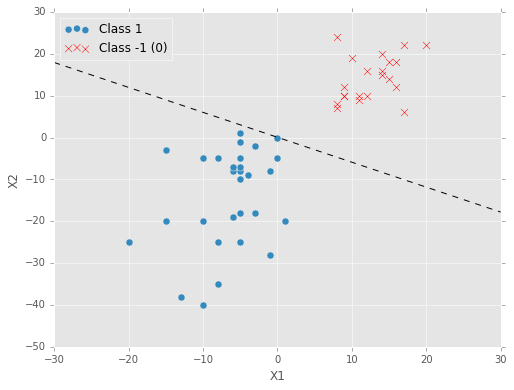

In epoch 471 the error is 0.000195374555963
In epoch 472 the error is 0.000195185644663
In epoch 473 the error is 0.000194997096645
In epoch 474 the error is 0.000194808910866
In epoch 475 the error is 0.000194621086287
In epoch 476 the error is 0.000194433621871
In epoch 477 the error is 0.000194246516587
In epoch 478 the error is 0.000194059769407
In epoch 479 the error is 0.000193873379307
In epoch 480 the error is 0.000193687345268

\begin{figure}[ht]
	\label{fig:epoch_480}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_480.png}
	\caption{Epoch 480 with a learning rate $\eta=0.1$, $err=1.9369e-04$}
\end{figure}



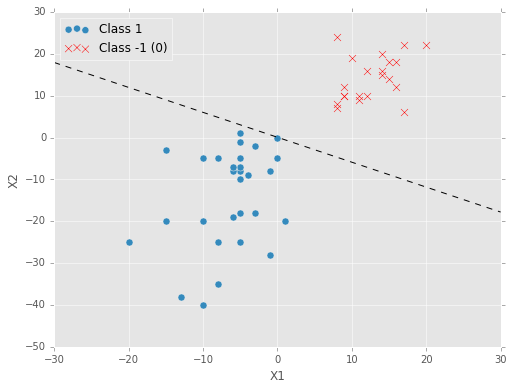

In epoch 481 the error is 0.000193501666272
In epoch 482 the error is 0.000193316341307
In epoch 483 the error is 0.000193131369366
In epoch 484 the error is 0.000192946749443
In epoch 485 the error is 0.000192762480538
In epoch 486 the error is 0.000192578561653
In epoch 487 the error is 0.000192394991796
In epoch 488 the error is 0.000192211769976
In epoch 489 the error is 0.000192028895209
In epoch 490 the error is 0.00019184636651

\begin{figure}[ht]
	\label{fig:epoch_490}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_490.png}
	\caption{Epoch 490 with a learning rate $\eta=0.1$, $err=1.9185e-04$}
\end{figure}



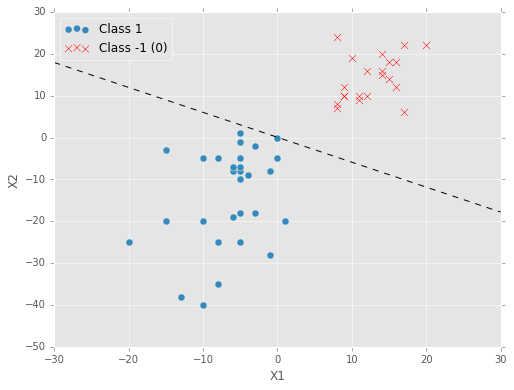

In epoch 491 the error is 0.000191664182904
In epoch 492 the error is 0.000191482343413
In epoch 493 the error is 0.000191300847069
In epoch 494 the error is 0.000191119692902
In epoch 495 the error is 0.000190938879949
In epoch 496 the error is 0.000190758407251
In epoch 497 the error is 0.00019057827385
In epoch 498 the error is 0.000190398478793
In epoch 499 the error is 0.000190219021131
In epoch 500 the error is 0.000190039899918

\begin{figure}[ht]
	\label{fig:epoch_500}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_500.png}
	\caption{Epoch 500 with a learning rate $\eta=0.1$, $err=1.9004e-04$}
\end{figure}



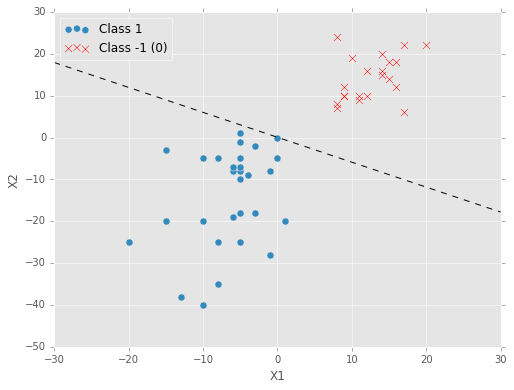

In epoch 501 the error is 0.000189861114211
In epoch 502 the error is 0.000189682663072
In epoch 503 the error is 0.000189504545565
In epoch 504 the error is 0.000189326760758
In epoch 505 the error is 0.000189149307723
In epoch 506 the error is 0.000188972185535
In epoch 507 the error is 0.000188795393271
In epoch 508 the error is 0.000188618930015
In epoch 509 the error is 0.00018844279485
In epoch 510 the error is 0.000188266986866

\begin{figure}[ht]
	\label{fig:epoch_510}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_510.png}
	\caption{Epoch 510 with a learning rate $\eta=0.1$, $err=1.8827e-04$}
\end{figure}



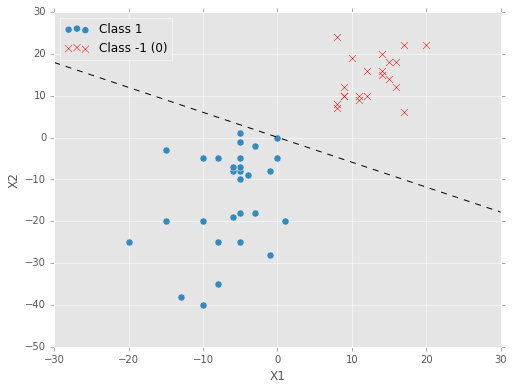

In epoch 511 the error is 0.000188091505155
In epoch 512 the error is 0.000187916348811
In epoch 513 the error is 0.000187741516934
In epoch 514 the error is 0.000187567008625
In epoch 515 the error is 0.00018739282299
In epoch 516 the error is 0.000187218959137
In epoch 517 the error is 0.000187045416178
In epoch 518 the error is 0.000186872193227
In epoch 519 the error is 0.000186699289405


KeyboardInterrupt: 

In [15]:
theta = train_model(data, learning_rate=0.1, should_graph=1, graph_interval=10, min_delta_error=10**-7)
plot_data(data, theta)

In [14]:
evaluate_convergence_rate(data)

/Users/guydavidson/Virtualenvs/dev/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: overflow encountered in exp


KeyboardInterrupt: 


\begin{figure}[ht]
	\label{fig:final}
	\includegraphics[width=0.95\textwidth]{learning_plot_final.png}
	\caption{Final model, with $err=4.212 \times 10^{-07}$, with parameters $b_0 = 10.768$, $b_1 = -222.072$, and $b_2 = -348.229$.}
\end{figure}



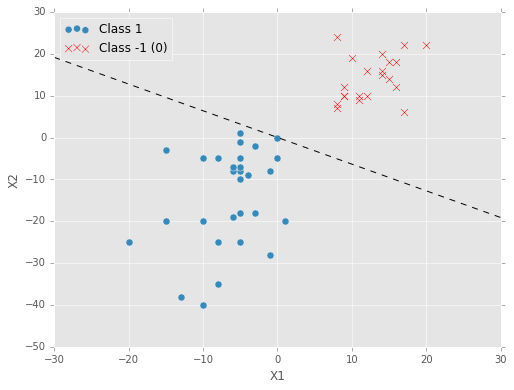

In [85]:
plot_data(data, theta, 'learning_plot_final.png', 'final', 
          'Final model, with $err=4.212 \\times 10^{-07}$, with parameters ' + \
            '$b_0 = 10.768$, $b_1 = -222.072$, and $b_2 = -348.229$.')

In [8]:
theta

array([  12.54130531, -441.36184812, -702.96565816])

In [ ]:
loss_function(data, theta)

In [ ]:
generate_relevant_columns(data, True)

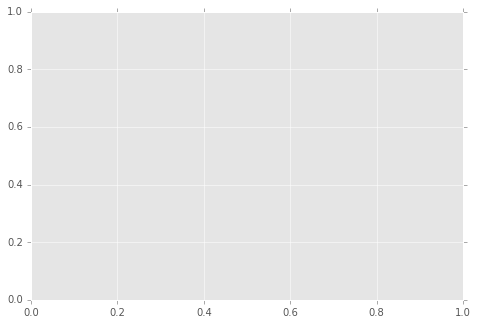